In [1]:
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from matplotlib import animation

tau = 2 * np.pi

In [4]:
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

# Append parent dir to path, so that other modules can be imported.
sys.path.append(parent_dir)

In [17]:
from modules.visualize import plot_complex, double_plot
from fourier_core import compute_coeffs, fourier_series, compute_fourier_approximation

### Some functions with real domain, $f(x) \in \mathbb{R}$

In [18]:
from modules import pathological_functions

input_range = np.linspace(0,1, 1000)

# linear
points = input_range

# unit impulse
points = np.zeros_like(points)
points[500] = 1

# box
points = np.ones_like(input_range)
points[0] = 0
points[-1] = 0

# step
points = np.ones_like(input_range)
points[:500] = 0

input_range, points = pathological_functions.prime_staircase()
points = input_range + 1j*points

We can wrap the function around a circle, approximate the wrapped function and finally undo the wrapping.

$t \in [0,1]$ with same len as x

$\theta \in [-\frac{\tau}{4},\frac{\tau}{4}]$ the semicircle facing right D

$x = \cos(\theta) = \cos(\frac{\tau}{2}(t-\frac{1}{2}))$

$x \in [0,1]$ rescale these values to the range of original x

$ y = f(x) = points $

In [19]:
def change_range(old_value, new_range, old_range=None):
  if old_range == None:
    old_range = (old_value.min(), old_value.max())
  old_ptp = old_range[1] - old_range[0]
  new_ptp = new_range[1] - new_range[0]
  return ((old_value - old_range[0]) * new_ptp) / old_ptp + new_range[0]

def wrap_around_circle(points):
  t = np.linspace(0, 1, len(points))
  # wrap linear to circular
  x = np.cos(tau/2 * (t-0.5))
  x = change_range(x, new_range=(points.real.min(),points.real.max()))
  return x + 1j*points.imag

def unwrap_from_circle(points):
  x = change_range(points.real, (0,1))
  x = np.arccos(x) * 2/tau + 0.5
  x[:len(x)//2] = 1 - x[:len(x)//2]
  x = change_range(x, (points.real.min(), points.real.max()))
  return x + 1j*points.imag

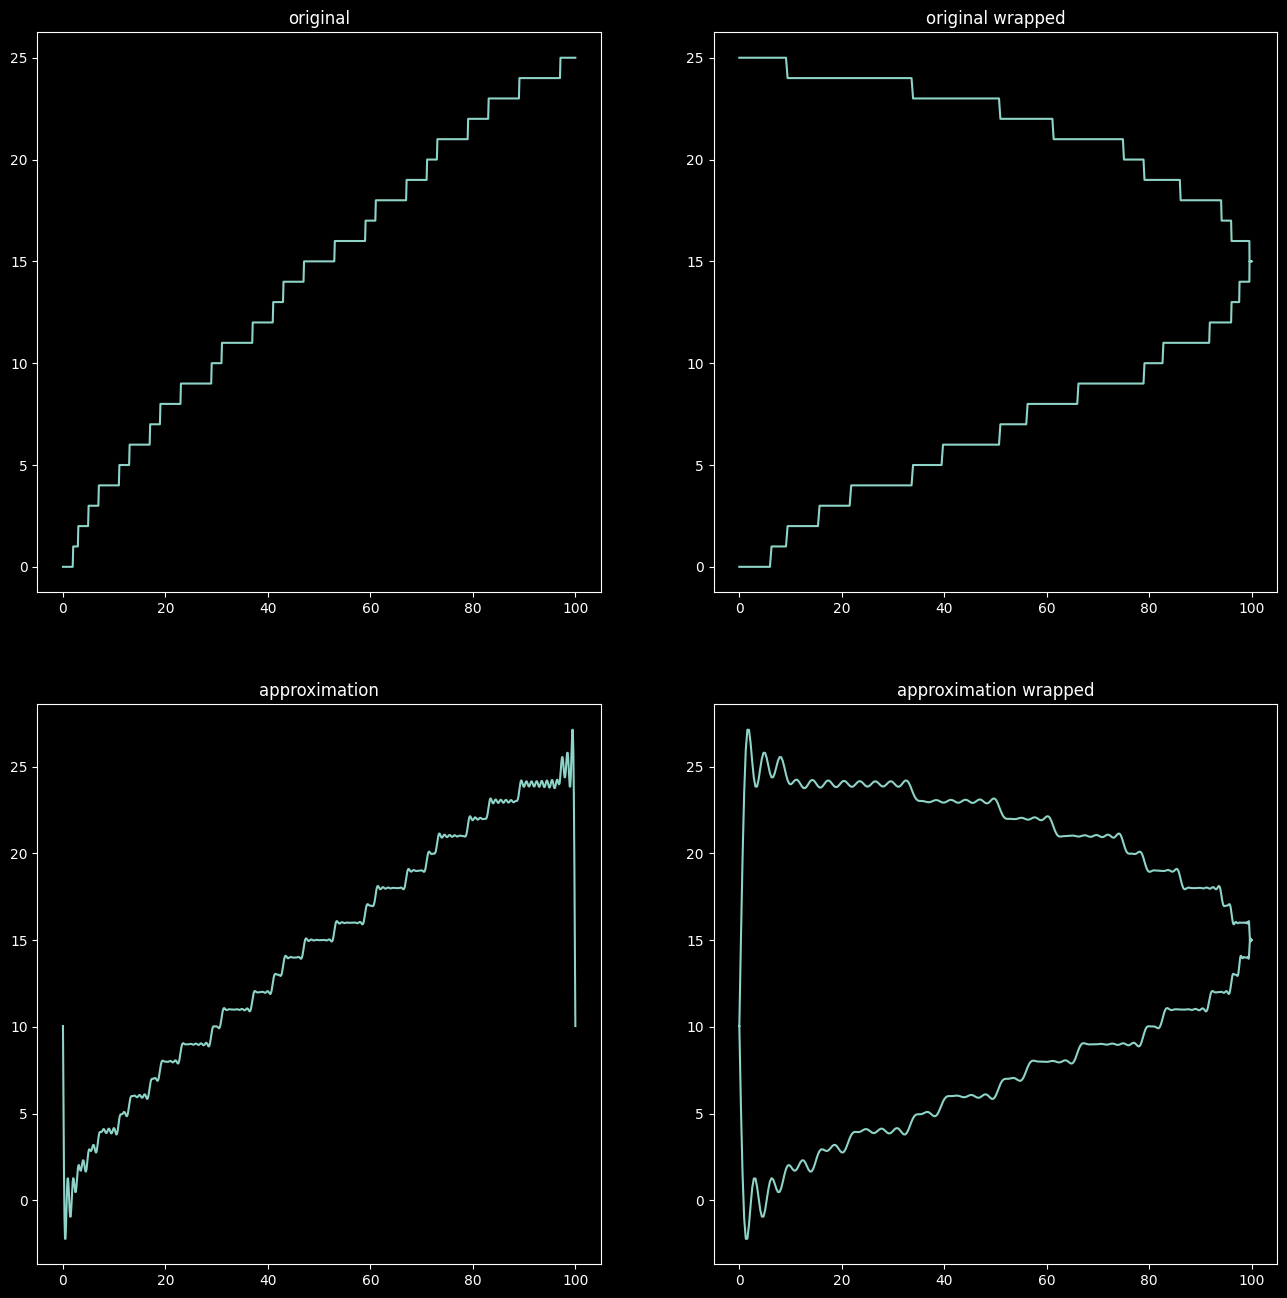

In [8]:
num_coeffs = 201
# imaginary components exists because of its dtype but its value is 0
points_appr = compute_fourier_approximation(points.imag, num_coeffs, num_samples=len(points)).real
points_appr = input_range + 1j*points_appr


fig, axs = plt.subplots(2,2, figsize=(16, 16))

plt.sca(axs[0,0])
plt.title('original')
plot_complex(points)

plt.sca(axs[0,1])
plt.title('original wrapped')
points_wrapped = wrap_around_circle(points)
plot_complex(points_wrapped)

plt.sca(axs[1,0])
plt.title('approximation')
plot_complex(points_appr)

plt.sca(axs[1,1])
plt.title('approximation wrapped')
points_appr_wrapped = wrap_around_circle(points_appr)
plot_complex(points_appr_wrapped)

plt.show()

### Approximation animation

#### Evolution (Coeff progression)

In [9]:
from modules.fourier_utils import compute_apprs
from modules.visualize import evolution_animate

approximating original points

In [10]:
num_coeffs = 301
coeffs = compute_coeffs(points.imag, num_coeffs)

# print(coeffs[1] + coeffs[-1])
# Sum of pairs of coeffs will always have imaginary component as 0.

points_apprs = compute_apprs(points.imag, coeffs).real
points_apprs = input_range + 1j*points_apprs

calculating approximations:   0%|          | 0/301 [00:00<?, ?it/s]

In [16]:
# At every even index we have sum of c_n and c_-n
anim = evolution_animate(points_apprs[0::2])
anim.save(f"{parent_dir}/animations/evolution.gif", writer=animation.PillowWriter(fps=10))

generating evolution animation:   0%|          | 0/151 [00:00<?, ?it/s]

#### Epicycles (Time progression)

In [20]:
from modules.visualize import epicycles_animate

In [21]:
from modules.fourier_utils import compute_circle_centers


num_coeffs = 71
points_wrapped = wrap_around_circle(points)
coeffs = compute_coeffs(points_wrapped, num_coeffs)
n_samples = 1000  # number of time points to sample

# At every even index we have sum of c_n and c_-n
centers_time_wrapped = compute_circle_centers(coeffs, n_samples, sort=False)

calculating centers and radii:   0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
centers_time_unwrapped = np.apply_along_axis(unwrap_from_circle, axis=0, arr=centers_time_wrapped)

In [ ]:
# Just save the wrapped curve.
# anim = epicycles_animate(centers_time, detail=13, show_stats=True)
# anim.save(f"animations/epicycles_{num_coeffs}.gif", writer=animation.PillowWriter(fps=20))

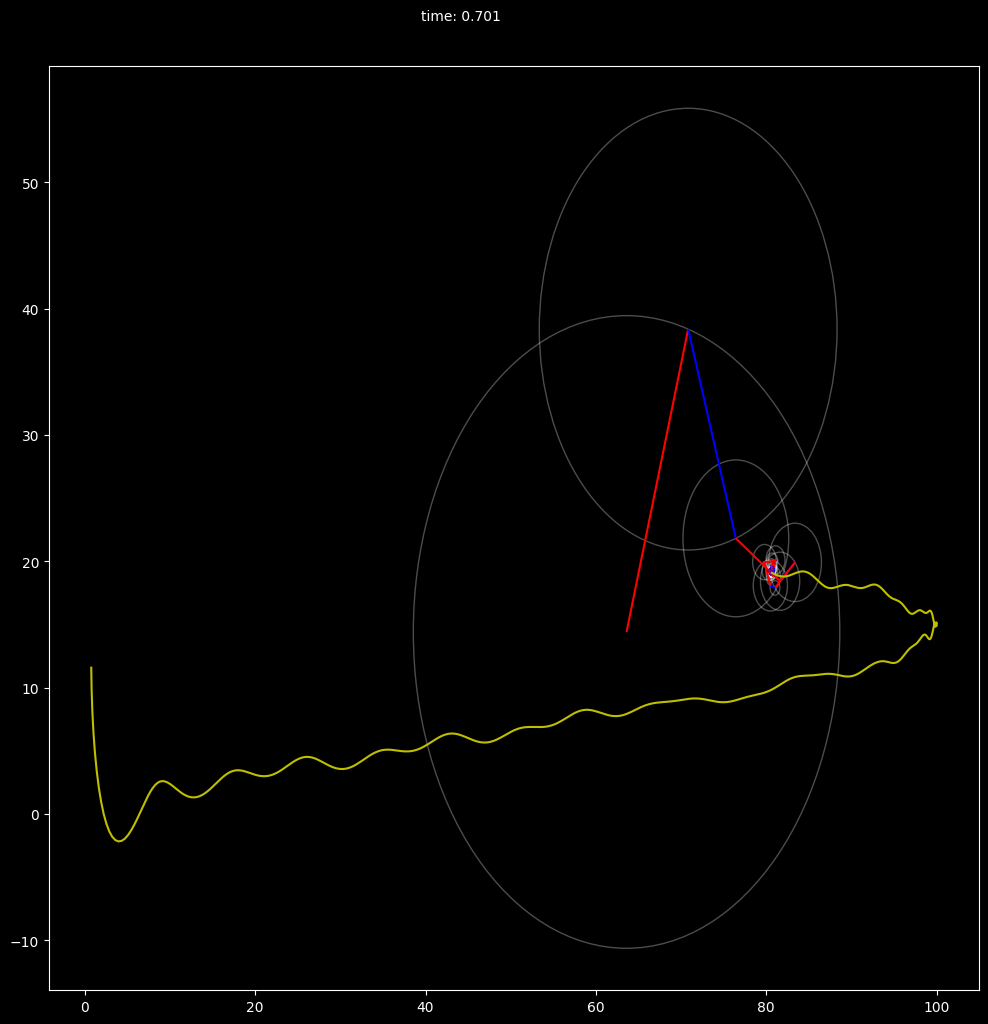

In [24]:
from matplotlib.collections import LineCollection
from matplotlib.collections import PatchCollection

fig, ax = plt.subplots(figsize=(12,12))
i = int(n_samples * 0.7)

centers = centers_time_wrapped[i]
radii = abs(np.diff(centers))
lines = np.column_stack((centers[:-1], centers[1:]))

colors = ['r' if i%2==0 else 'b' for i in range(len(lines))]
coll_lines = LineCollection(np.dstack([lines.real, lines.imag]), colors=colors)



patches = [plt.Circle((center.real, center.imag), radius) for center, radius in zip(centers, radii)]
coll_circles = PatchCollection(patches, alpha=0.3, color='white', facecolor='None')

ax.add_collection(coll_lines)
ax.add_collection(coll_circles)


# Plot curve.
plot_complex(centers_time_wrapped[:i+1, -1], c='y')
plt.text(0.4, 1.05, f'time: {i/(n_samples-1):.3f}', transform = plt.gca().transAxes)
plt.show()

In [25]:
from celluloid import Camera
from modules.visualize import compute_arrows
from modules.visualize import plot_circles, compute_orientations

def _plot_epicycles_frame(centers, colors, curve_wrapped, curve_unwrapped, detail, ax=None):
  """
    detail =  0: only curve
    detail =  1: white lines
    detail =  3: arrowed white lines
    detail =  7: arrowed white lines with circles
    detail = 10: colored (blue & red) lines
    detail = 13: colored (blue & red) lines with arrows
    detail = 17: colored (blue & red) lines with circles
  """
  ax = plt.gca() if ax is None else ax
  radii = abs(np.diff(centers))
  lines = np.column_stack((centers[:-1], centers[1:]))
  # theta = np.linspace(0, tau, 36)
  # circles = centers[:-1][:,None] + radii[:,None] * np.exp(1j * theta.T)

  if detail >= 1 and detail < 10:
    plot_complex(centers, color='white')
    if detail >= 3:
      arrows = compute_arrows(lines)
      plot_complex(arrows.T, color='white')
    if detail >= 7:
      plot_circles(centers, radii)

  elif detail >= 10 and detail < 20:
    # Problem with z order of lines.
    # plot_colored_lines(lines)
    
    # Handles z order properly.
    coll_lines = LineCollection(np.dstack([lines.real, lines.imag]), colors=colors)
    ax.add_collection(coll_lines)
    if detail >= 13:
      arrows = compute_arrows(lines)
      # plot_colored_lines(arrows)
      coll_arrows = LineCollection(np.dstack([arrows.real, arrows.imag]), colors=colors)
      ax.add_collection(coll_arrows)
    if detail >= 17:
      plot_circles(centers, radii)

  # Plot curve drawn so far.
  plot_complex(curve_wrapped, color='yellow')
  plot_complex(curve_unwrapped, color='yellow')
  plt.plot((curve_wrapped[-1].real, curve_unwrapped[-1].real),
           (curve_wrapped[-1].imag, curve_unwrapped[-1].imag),
           color='white', alpha=0.3, linestyle='--')


def epicycles_animate(centers_time, centers_time_unwrapped, detail=7, show_stats=True, add_origin=False):
  fig, ax = plt.subplots(figsize=(6,6))  # Using default figsize.
  camera = Camera(fig)
  # plt.axis('off')
  plt.gca().set_aspect('equal')

  n_samples, n_centers = centers_time.shape

  if add_origin:
    # Add (0,0) as the first center.
    centers_time = np.hstack((np.zeros((n_samples, 1)), centers_time))

  orientations = compute_orientations(centers_time[0], centers_time[1])
  colors = []
  for orientation in orientations:
    if orientation == 0: colors.append('white')
    elif orientation == 1: colors.append('red')
    elif orientation == -1: colors.append('blue')
  # Shift the wrapped centers to the left.
  centers_time = (centers_time.real - np.ptp(centers_time.real)) + 1j*centers_time.imag
  # Looping the data and capturing frame at each iteration.
  for i, centers in enumerate(tqdm(centers_time, desc='generating epicycles animation')):
    _plot_epicycles_frame(centers, colors,
                          curve_wrapped=centers_time[:i+1, -1],
                          curve_unwrapped=centers_time_unwrapped[:i+1, -1],
                          detail=detail, ax=ax)
    if show_stats:  # Display the elapsed time
      plt.text(0.4, 1.05, f'time: {i / (n_samples-1):.3f}', transform = ax.transAxes)

    camera.snap()
  plt.close(fig)

  anim = camera.animate()
  return anim


In [26]:
anim = epicycles_animate(centers_time_wrapped, centers_time_unwrapped, detail=13, show_stats=True)
anim.save(f"{parent_dir}/animations/epicycles_{num_coeffs}.gif", writer=animation.PillowWriter(fps=20))

generating epicycles animation:   0%|          | 0/1000 [00:00<?, ?it/s]